In [2]:
from google.colab import drive
drive.mount('./gdrive')

Mounted at ./gdrive


In [4]:
import os
os.chdir("/content/gdrive/MyDrive/ML Project/Mushroom Research Paper")

In [8]:
import numpy as np 
import pandas as pd 
import random

import cv2
import os
clss = os.listdir()
clss

['rawDataV2',
 'rawData',
 'IJRTE_Paper_Template.doc',
 'Untitled0.ipynb',
 'Mushroom notes.docx',
 'PredictionFromDenseNet',
 'Mushroom k2.docx',
 'fullScaleClassifier.ipynb',
 'INTRODUCTION.docx',
 'Agaricus Bisporus',
 'Death Cap',
 'Galerina Autumnalis',
 'Oyster',
 'rawDataFull_Shuflled',
 'rawDataFULL']

In [10]:
num_classes = 4
labels_name={'Agaricus Bisporus':0,'Death Cap':1,'Galerina Autumnalis':2,'Oyster':3}
num_images_for_test = 200
train_df = pd.DataFrame(columns=['FileName', 'Label', 'ClassName'])
test_df = pd.DataFrame(columns=['FileName', 'Label', 'ClassName'])
data_dir_list = ["Agaricus Bisporus", "Death Cap", "Galerina Autumnalis", "Oyster"]

In [12]:
for dataset in data_dir_list:
    # load the list of image names in each of the flower category
    img_list = os.listdir(os.path.join(os.getcwd(),dataset))
    print ('Loading the images of dataset-'+'{}\n'.format(dataset))
    label = labels_name[dataset]
    num_img_files = len(img_list)
    num_corrupted_files=0
    test_list_index = random.sample(range(1, num_img_files-1), num_images_for_test)
    
    # read each file and if it is corrupted exclude it , if not include it in either train or test data frames
    for i in range(num_img_files):
        img_name = img_list[i]
        img_filename = os.path.join(os.getcwd(),dataset,img_name)
        try:
            input_img = cv2.imread(img_filename)
            img_shape=input_img.shape
            if i in test_list_index:
                test_df = test_df.append({'FileName': img_filename, 'Label': label,'ClassName': dataset},ignore_index=True)
            else:
                train_df = train_df.append({'FileName': img_filename, 'Label': label,'ClassName': dataset},ignore_index=True)       
        except:
            print ('{} is corrupted\n'.format(img_filename))
            num_corrupted_files+=1
    
    print ('Read {0} images out of {1} images from data dir {2}\n'.format(num_img_files-num_corrupted_files,num_img_files,dataset))

print ('completed reading all the image files and assigned labels accordingly')

Loading the images of dataset-Agaricus Bisporus

Read 458 images out of 458 images from data dir Agaricus Bisporus

Loading the images of dataset-Death Cap

Read 529 images out of 529 images from data dir Death Cap

Loading the images of dataset-Galerina Autumnalis

Read 521 images out of 521 images from data dir Galerina Autumnalis

Loading the images of dataset-Oyster

/content/gdrive/My Drive/ML Project/Mushroom Research Paper/Oyster/pic_001.gif is corrupted

Read 703 images out of 704 images from data dir Oyster

completed reading all the image files and assigned labels accordingly


In [14]:
if not os.path.exists('data_files'):
    os.mkdir('data_files')

train_df.to_csv('data_files/flowers_recognition_train.csv')
test_df.to_csv('data_files/flowers_recognition_test.csv')
print('The train and test csv files are saved')

import pickle as pkl
with open('data_files/label_map.pkl', 'wb') as handle:
    pkl.dump(labels_name, handle, protocol=pkl.HIGHEST_PROTOCOL)

The train and test csv files are saved


ACTUAL MODEL

In [36]:
import os

import numpy as np
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt


import cv2
from sklearn.utils import shuffle

from config import Config
from keras.utils import np_utils

ModuleNotFoundError: ignored

In [17]:

def load_samples(csv_file):
    data = pd.read_csv(os.path.join('data_files',csv_file))
    data = data[['FileName', 'Label', 'ClassName']]
    file_names = list(data.iloc[:,0])
    # Get the labels present in the second column
    labels = list(data.iloc[:,1])
    samples=[]
    for samp,lab in zip(file_names,labels):
        samples.append([samp,lab])
    return samples

In [18]:
data_path = 'flowers_recognition_train.csv'
samples = load_samples(data_path)

In [19]:
print (samples[0:5])

[['/content/gdrive/My Drive/ML Project/Mushroom Research Paper/Agaricus Bisporus/pic_004.jpg', 0], ['/content/gdrive/My Drive/ML Project/Mushroom Research Paper/Agaricus Bisporus/pic_001.jpg', 0], ['/content/gdrive/My Drive/ML Project/Mushroom Research Paper/Agaricus Bisporus/pic_003.jpg', 0], ['/content/gdrive/My Drive/ML Project/Mushroom Research Paper/Agaricus Bisporus/pic_017.jpg', 0], ['/content/gdrive/My Drive/ML Project/Mushroom Research Paper/Agaricus Bisporus/pic_010.jpg', 0]]


In [20]:
def shuffle_data(data):
    data = shuffle(data)#,random_state=2)
    return data

In [23]:
def generator(samples, batch_size=32,shuffle_data=True,resize=224):
    """
    Yields the next training batch.
    Suppose `samples` is an array [[image1_filename,label1], [image2_filename,label2],...].
    """
    num_samples = len(samples)
    while True: # Loop forever so the generator never terminates
        samples = shuffle(samples)

        # Get index to start each batch: [0, batch_size, 2*batch_size, ..., max multiple of batch_size <= num_samples]
        for offset in range(0, num_samples, batch_size):
            # Get the samples you'll use in this batch
            batch_samples = samples[offset:offset+batch_size]

            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []

            # For each example
            for batch_sample in batch_samples:
                # Load image (X) and label (y)
                img_name = batch_sample[0]
                label = batch_sample[1]
                img =  cv2.imread(os.path.join("",img_name))
                
                # apply any kind of preprocessing
                img = cv2.resize(img,(resize,resize))
                # Add example to arrays
                X_train.append(img)
                y_train.append(label)

            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            y_train = np.array(y_train)

            # The generator-y part: yield the next training batch            
            yield X_train, y_train

In [24]:

# this will create a generator object
train_datagen = generator(samples,batch_size=8)

x,y = next(train_datagen)

In [25]:
print ('x_shape: ', x.shape)
print ('labels: ', y)

x_shape:  (8, 224, 224, 3)
labels:  [3 1 3 3 2 0 1 0]


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

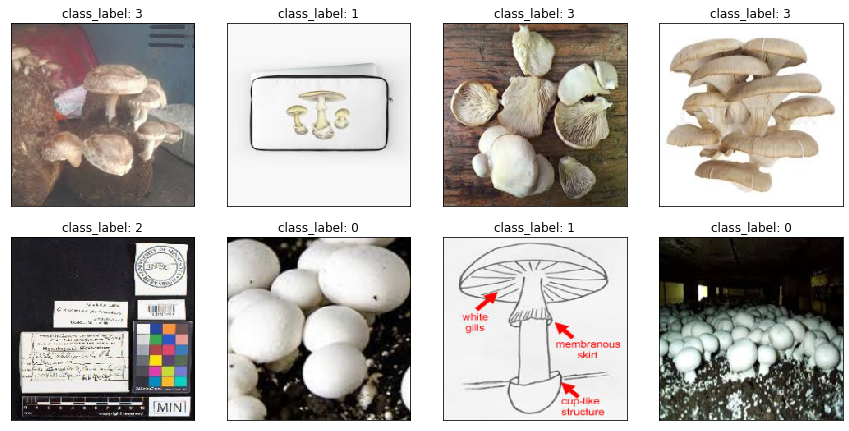

In [26]:
fig = plt.figure(1,figsize=(12,12))
for i in range(8):
  plt.subplot(4,4,i+1)
  plt.tight_layout()
  #x[i] = x[i][:,:,::-1] # converting BGR to RGB
  plt.imshow(x[i][:,:,::-1], interpolation='none')
  plt.title("class_label: {}".format(y[i]))
  plt.xticks([])
  plt.yticks([])
plt

In [37]:
def preprocessing(img,label):
    img = cv2.resize(img,(300,300))
    img = img/255
    label = np_utils.to_categorical(label, 4)
    return img,label

In [38]:

def data_generator(samples, batch_size=32,shuffle_data=True,resize=224):
    """
    Yields the next training batch.
    Suppose `samples` is an array [[image1_filename,label1], [image2_filename,label2],...].
    """
    num_samples = len(samples)
    while True: # Loop forever so the generator never terminates
        samples = shuffle(samples)

        # Get index to start each batch: [0, batch_size, 2*batch_size, ..., max multiple of batch_size <= num_samples]
        for offset in range(0, num_samples, batch_size):
            # Get the samples you'll use in this batch
            batch_samples = samples[offset:offset+batch_size]

            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []

            # For each example
            for batch_sample in batch_samples:
                # Load image (X) and label (y)
                img_name = batch_sample[0]
                label = batch_sample[1]
                img =  cv2.imread(os.path.join("",img_name))
                
                # apply any kind of preprocessing
                img,label = preprocessing(img,label)
                # Add example to arrays
                X_train.append(img)
                y_train.append(label)

            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            y_train = np.array(y_train)

            # The generator-y part: yield the next training batch            
            yield X_train, y_train

In [39]:

# this will create a generator object
train_datagen = data_generator(samples,batch_size=8)

x,y = next(train_datagen)
print ('x_shape: ', x.shape)
print ('labels shape: ', y.shape)
print ('labels: ', y)

x_shape:  (8, 300, 300, 3)
labels shape:  (8, 4)
labels:  [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]]


In [40]:

train_data_path = 'flowers_recognition_train.csv'
test_data_path = 'flowers_recognition_test.csv'

train_samples = load_samples(train_data_path)
test_samples = load_samples(test_data_path)

num_train_samples = len(train_samples)
num_test_samples = len(test_samples)

print ('number of train samples: ', num_train_samples)
print ('number of test samples: ', num_test_samples)

number of train samples:  1412
number of test samples:  799


In [41]:
# Create generator
batch_size = 10
train_generator = data_generator(train_samples, batch_size=32)
validation_generator = data_generator(test_samples, batch_size=32)

In [44]:
# import the necessary modules from the library
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Activation, MaxPooling2D, Dropout

input_shape = (300,300,3)
print (input_shape)

model = Sequential()

#filters,kernel_size,strides=(1, 1),padding='valid',data_format=None,dilation_rate=(1, 1),activation=None,use_bias=True,
#kernel_initializer='glorot_uniform',bias_initializer='zeros',kernel_regularizer=None,bias_regularizer=None,
#activity_regularizer=None,kernel_constraint=None,bias_constraint=None,

#pool_size=(2, 2), strides=None, padding='valid',data_format=None

model.add(Conv2D(32, (3,3),padding='same',input_shape=input_shape,name='conv2d_1'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),name='maxpool2d_1'))

model.add(Conv2D(32, (3, 3),name='conv2d_2'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),name='maxpool2d_2'))

model.add(Dropout(0.5))

#model.add(Convolution2D(64, 3, 3))
#model.add(Activation('relu'))
#model.add(Convolution2D(64, 3, 3))
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(4))
model.add(Activation('softmax'))

(300, 300, 3)


In [45]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 300, 300, 32)      896       
_________________________________________________________________
activation_3 (Activation)    (None, 300, 300, 32)      0         
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 148, 148, 32)      9248      
_________________________________________________________________
activation_4 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
maxpool2d_2 (MaxPooling2D)   (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 74, 74, 32)       

In [46]:
model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer='sgd')

In [48]:
model.fit_generator(
        train_generator,
        steps_per_epoch=num_train_samples // batch_size,
        epochs=5,
        validation_data=validation_generator,
        validation_steps=num_test_samples // batch_size)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
141/141 [==============================] - 479s 3s/step - loss: 1.3027 - acc: 0.4031 - val_loss: 1.2361 - val_acc: 0.4451
Epoch 2/5
141/141 [==============================] - 460s 3s/step - loss: 1.1491 - acc: 0.5198 - val_loss: 1.1514 - val_acc: 0.5010
Epoch 3/5
141/141 [==============================] - 457s 3s/step - loss: 1.0527 - acc: 0.5593 - val_loss: 1.0148 - val_acc: 0.5529
Epoch 4/5
141/141 [==============================] - 455s 3s/step - loss: 0.9544 - acc: 0.6219 - val_loss: 1.0270 - val_acc: 0.5434
Epoch 5/5
141/141 [==============================] - 456s 3s/step - loss: 0.8871 - acc: 0.6378 - val_loss: 1.0043 - val_acc: 0.5596
